In [15]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
GOOGLEMODEL = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

GOOGLEMODEL['hello'].shape

(300,)

In [22]:
full_df = pd.read_json("../data/Appliances.json", lines = True)

# full_df.info()

full_df = full_df.dropna(subset=['reviewText'])

full_df.isna().sum()

# full_df.info()

full_df['overall'].unique()

full_df = full_df[:400000]

print(full_df['overall'].value_counts())

features = full_df['reviewText']
target = full_df['overall']

features = features.to_numpy().reshape(-1, 1)

sampler = RandomUnderSampler(sampling_strategy='majority', random_state=69)

feat_samp, targ_samp = sampler.fit_resample(features, target)

print(targ_samp.value_counts())

overall
5    278446
4     51958
1     35568
3     20660
2     13368
Name: count, dtype: int64
overall
4    51958
1    35568
3    20660
2    13368
5    13368
Name: count, dtype: int64


In [23]:

tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

corpus = feat_samp

review_list = []

for review in corpus:
    if isinstance(review[0], str):
        tokens = tokenizer.tokenize(review[0].lower())
        review_string = ''
        for word in tokens:
            review_string += word + ' '

        review_list.append(review_string) 

review_series = pd.Series(review_list)

vectorizer = CountVectorizer(stop_words='english')

X = vectorizer.fit_transform(review_series)

# Make a dataframe for machine learning
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df = df.reset_index()

df['overall_rating'] = targ_samp

print(df.shape)
df.head()


MemoryError: Unable to allocate 38.1 GiB for an array with shape (37866, 134922) and data type int64

In [4]:
vocab = df.columns[:-1]

vocab[:10]

len(vocab)

df.shape

(85198, 41225)

In [5]:
from tqdm import tqdm

W2V_list = []

features = df.drop(columns='overall_rating')

with tqdm(total=df.shape[0]) as pbar:
    for i in range(df.shape[0]):
        pbar.update(1)
        sentence = np.zeros(300)

        indices = np.where(np.array(features.iloc[i, :] >= 1))[0]

        for index in indices:
            word = vocab[index]
            if word in GOOGLEMODEL.key_to_index.keys():
                sentence = sentence + GOOGLEMODEL[word]

        W2V_list.append(sentence)

    W2V_df = pd.DataFrame(W2V_list)

print(W2V_df.shape)
W2V_df.head()


 14%|█▍        | 12036/85198 [01:55<11:41, 104.31it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Scratticus\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Scratticus\AppData\Local\Temp\ipykernel_39176\691676107.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Scratticus\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Scratticus\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Scratticus\AppData\Roaming\Python\Python311\site-packages\IPython\core\ul

In [ ]:
scaler = MinMaxScaler()
feature_W2V = scaler.fit_transform(W2V_df)

X_train, X_test, y_train, y_test = train_test_split(feature_W2V, df['overall_rating'], test_size=0.25, random_state=69)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(63774, 300)
(63774,)
(21259, 300)
(21259,)


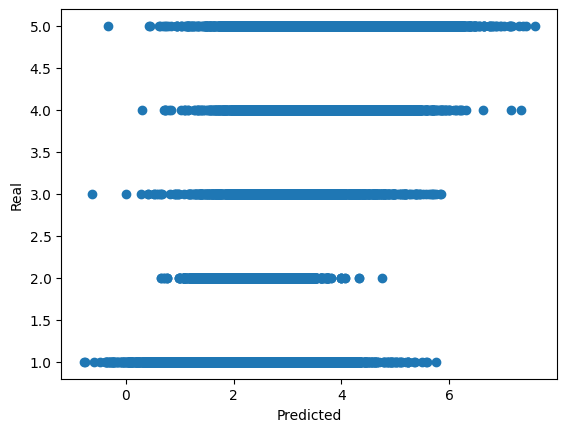

In [ ]:
hgbr = HistGradientBoostingRegressor(learning_rate=0.5, max_depth=1000)
hgbr.fit(X_train, y_train)
y_pred = hgbr.predict(X_test)

y_pred_series = pd.Series(y_pred)

plt.scatter(x=y_pred, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Real');

In [ ]:
y_pred_cut = y_cut = pd.cut(x=y_pred, bins=[y_pred.min(),1.5,2.5,3.5,4.5,y_pred.max()], labels=[1,2,3,4,5], include_lowest=True)

orig_acc = accuracy_score(y_test, y_pred_cut)
orig_pre = precision_score(y_test, y_pred_cut, average='weighted')
orig_rec = recall_score(y_test, y_pred_cut, average='weighted')
orig_f1 = f1_score(y_test, y_pred_cut, average='weighted')
orig_r2 = r2_score(y_test, y_pred_cut)
orig_mse = mean_squared_error(y_test, y_pred_cut)

print(f'Final HGBR results:')
print(f'Accuracy: {orig_acc}\nPrecision: {orig_pre}\nRecall: {orig_rec}\nF1 Score {orig_f1}\nR Squared: {orig_r2}\nMSE: {orig_mse}')


Final HGBR results:
Accuracy: 0.47048308951502893
Precision: 0.6539352051743964
Recall: 0.47048308951502893
F1 Score 0.5028820413138744
R Squared: 0.4551035616711008
MSE: 1.3632814337457078
